In [1]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import cm
from matplotlib.ticker import LinearLocator
from mpl_toolkits.mplot3d import Axes3D
from scipy.interpolate import griddata
import pandas as pd
import datetime
from sklearn.linear_model import LinearRegression, LogisticRegression, Ridge, BayesianRidge
from sklearn.model_selection import train_test_split, KFold, LeaveOneOut
from sklearn.metrics import mean_absolute_error

In [2]:
station_nodes = {"35": "Link_Port",
               "54": "Fort_Pierce",
               "55": "Vero_Beach",
               "56": "Sebastian",
               "62": "Jensen_Beach",
               "61": "St_Lucie_Estuary",
               "60": "Middle_Estuary",
               "58": "North_Fork",
               "57": "South_Fork",
               "68": "South_Fork_2"}

variable_abbreviation = {'date [EST]': 'date',
                         "chlorophyll [ug/L]": "chlorophyll",
                        "CDOM [QSDE]": "cdom",
                        "phosphate concentration [uM]": "phosphate",
                        "nitrate [uM]": "nitrate",
                        "dissolved oxygen [ml/l]": 'dissolved_oxygen',
                        'temperature [C]': 'temperature'}

def full_name(variable):
    global variable_abbreviation
    for key, value in variable_abbreviation.items():
        if value == variable:
            return key

In [3]:
LOBO_data_folder = '/Users/quachhungvietnam/Desktop/LOBO/LOBO_dataset/'
station_name = "South_Fork_2"
dataset = pd.read_csv(LOBO_data_folder+f'{station_name}.csv')
dataset['date'] = list(map(lambda value: datetime.datetime.strptime(value, '%Y-%m-%d %H:%M:%S'),
                          dataset['date']))
dataset

,date,chlorophyll,cdom,phosphate,nitrate,dissolved_oxygen,temperature,decimal_date
0,2017-01-01 00:00:00,4.21,53.18,2.25,16.8,1.32,23.51,0.000000
1,2017-01-01 01:00:00,4.26,52.45,1.97,13.4,1.06,23.62,0.041667
2,2017-01-01 02:00:00,6.11,52.31,1.87,12.3,0.98,23.65,0.083333
3,2017-01-01 03:00:00,5.19,51.62,1.70,15.9,0.88,23.61,0.125000
4,2017-01-01 04:00:00,4.63,51.97,1.55,15.0,1.09,23.49,0.166667
...,...,...,...,...,...,...,...,...
25944,2019-12-31 19:00:00,3.60,30.35,8.64,79.8,4.72,23.49,1094.791667
25945,2019-12-31 20:00:00,3.79,30.32,8.52,74.8,4.77,23.46,1094.833333
25946,2019-12-31 21:00:00,3.71,30.48,8.40,75.0,4.74,23.38,1094.875000
25947,2019-12-31 22:00:00,3.50,30.70,8.30,74.2,4.53,23.30,1094.916667


            nitrate  phosphate
nitrate    1.000000  -0.216493
phosphate -0.216493   1.000000


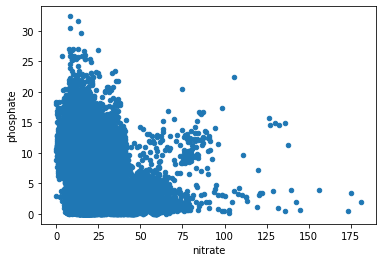

In [4]:
dataset.plot(x='nitrate', y='phosphate', kind='scatter')
print(dataset[['nitrate', 'phosphate']].corr())

In [6]:
reg_result_table = {"Increment":[],
                  "CDOM coef": [],
                  "Phosphate coef": [],
                  'Nitrate coef': [],
                  'MAE testing': []}

for hour_shift in range(1,24*3,1):
    next_chl = []
    for current_time in dataset['date']:
        time_shifted = current_time + datetime.timedelta(hours=hour_shift)
        x = dataset.loc[dataset['date']==time_shifted,'chlorophyll'].values
        if len(x) == 1:
            next_chl.append(x[0])
        else:
            next_chl.append(np.nan)
    dataset['next_chl'] = next_chl

    X_vars = ['cdom', 'phosphate', 'nitrate']
    y_vars = ['next_chl']
    sub_dataset = dataset[X_vars+y_vars].dropna()
    X = np.array(sub_dataset[X_vars])
    y = np.array(sub_dataset[y_vars])
    #reg = LinearRegression().fit(X,y)
    print(hour_shift)
    #reg_coef = reg.coef_[0]
    reg_result_table['Increment'].append(hour_shift)
    
    #20 fold cross validation:
    MAE_array = []
    coefs_array = [] #[CDOM, Phosphate, Nitrate] at each training set
    for train_index, test_index in KFold(n_splits=20).split(X):
        X_train, X_test = X[train_index], X[test_index]
        y_train, y_test = y[train_index], y[test_index]
        reg = LinearRegression().fit(X_train,y_train)
        y_pred = reg.predict(X_test)
        MAE_array.append(mean_absolute_error(y_test, y_pred))
        coefs_array.append(reg.coef_[0])
        
    reg_result_table['CDOM coef'].append([x[0] for x in coefs_array])
    reg_result_table['Phosphate coef'].append([x[1] for x in coefs_array])
    reg_result_table['Nitrate coef'].append([x[2] for x in coefs_array])
    reg_result_table['MAE testing'].append(np.mean(MAE_array))

1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71


In [7]:
reg_result_table = pd.DataFrame(reg_result_table)
reg_result_table

,Increment,CDOM coef,Phosphate coef,Nitrate coef,MAE testing
0,1,"[0.06540536555582033, 0.06953433169588936, 0.0...","[-0.012560705180232301, -0.058575170091964314,...","[-0.029440246481410175, -0.04000340106712537, ...",1.484367
1,2,"[0.0654227397774167, 0.06960613073776904, 0.07...","[-0.012648079862165826, -0.05862808887425012, ...","[-0.0294036228774661, -0.0399464760639132, -0....",1.484199
2,3,"[0.06540572302879953, 0.06963089855954474, 0.0...","[-0.012858694068192861, -0.058641564235365144,...","[-0.029239938000849276, -0.03980841415397664, ...",1.483709
3,4,"[0.06536878394038759, 0.06963457029198906, 0.0...","[-0.013112613910837123, -0.05904708763108135, ...","[-0.02921857997851371, -0.03978003672663552, -...",1.486044
4,5,"[0.06537703952274775, 0.06965936351033108, 0.0...","[-0.012842142282836838, -0.05877188125904659, ...","[-0.029009213147965188, -0.039564741108597076,...",1.485175
...,...,...,...,...,...
66,67,"[0.0635394856346419, 0.06895628517623979, 0.06...","[-0.001399365781753829, -0.04640156567478933, ...","[-0.023715546130162003, -0.03543059608063272, ...",1.510398
67,68,"[0.06334506436718788, 0.06882723781283885, 0.0...","[-0.001868068802694753, -0.04668919943792448, ...","[-0.02370684661293133, -0.0354556304212809, -0...",1.512643
68,69,"[0.06325731477280136, 0.06872025645431937, 0.0...","[-0.0018061909682629803, -0.04656257677132766,...","[-0.02372324525205988, -0.035458919668557555, ...",1.511069
69,70,"[0.06304867716949612, 0.06852168393978657, 0.0...","[-0.002449147313364716, -0.047267923243488295,...","[-0.023674740169886806, -0.03548530051876829, ...",1.512920


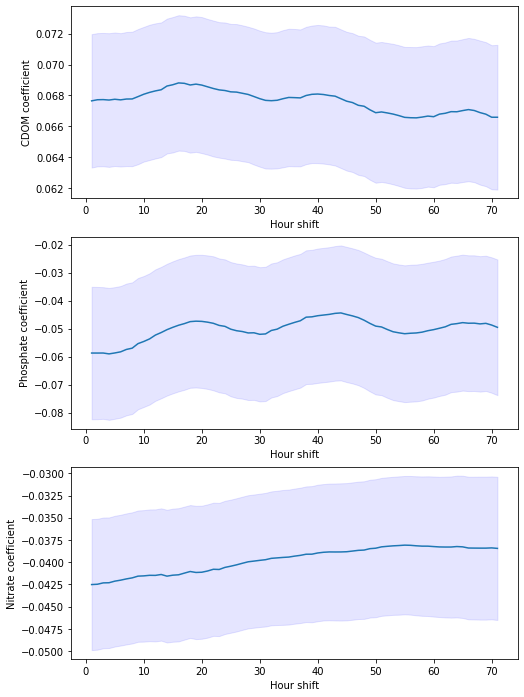

In [27]:
nrow, ncol = 3, 1
fig = plt.figure(figsize=(8*ncol,4*nrow))
i = 0
for coef in ['CDOM coef', 'Phosphate coef', 'Nitrate coef']:
    i += 1
    sub_data = reg_result_table[coef]
    ax = fig.add_subplot(nrow, ncol, i)
    x_array = reg_result_table['Increment']
    mean_y = np.array([np.mean(x) for x in sub_data])
    y_err = 1.96*np.array([np.std(x) for x in sub_data])
    ax.plot(x_array, mean_y)
    ax.fill_between(x_array, (mean_y-y_err), (mean_y+y_err), color='b', alpha=.1)
    ax.set_xlabel('Hour shift')
    ax.set_ylabel(coef+"ficient")

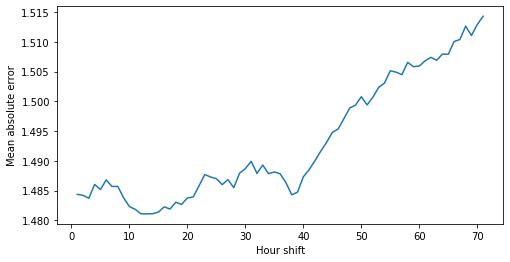

In [21]:
plt.figure(figsize=(8,4))
plt.plot(reg_result_table['Increment'], reg_result_table['MAE testing'])
plt.xlabel("Hour shift")
plt.ylabel("Mean absolute error")
plt.show()

In [4]:
dataset['N/P'] = dataset['nitrate']/dataset['phosphate']
print("% events when N/P >16 is: ", len(dataset.loc[dataset['N/P']>16,:])/len(dataset))

% events when N/P >16 is:  0.17576785232571582


In [5]:
dataset

,date,chlorophyll,cdom,phosphate,nitrate,dissolved_oxygen,temperature,decimal_date,N/P
0,2017-01-01 00:00:00,4.21,53.18,2.25,16.8,1.32,23.51,0.000000,7.466667
1,2017-01-01 01:00:00,4.26,52.45,1.97,13.4,1.06,23.62,0.041667,6.802030
2,2017-01-01 02:00:00,6.11,52.31,1.87,12.3,0.98,23.65,0.083333,6.577540
3,2017-01-01 03:00:00,5.19,51.62,1.70,15.9,0.88,23.61,0.125000,9.352941
4,2017-01-01 04:00:00,4.63,51.97,1.55,15.0,1.09,23.49,0.166667,9.677419
...,...,...,...,...,...,...,...,...,...
25944,2019-12-31 19:00:00,3.60,30.35,8.64,79.8,4.72,23.49,1094.791667,9.236111
25945,2019-12-31 20:00:00,3.79,30.32,8.52,74.8,4.77,23.46,1094.833333,8.779343
25946,2019-12-31 21:00:00,3.71,30.48,8.40,75.0,4.74,23.38,1094.875000,8.928571
25947,2019-12-31 22:00:00,3.50,30.70,8.30,74.2,4.53,23.30,1094.916667,8.939759


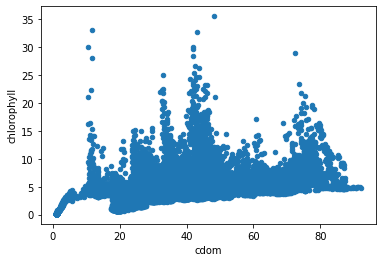

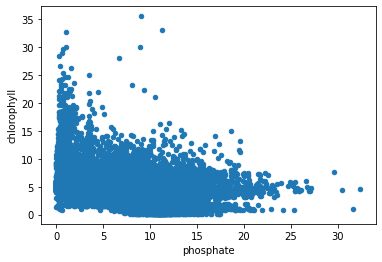

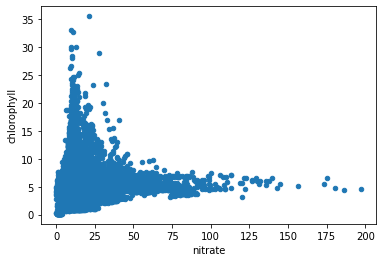

In [11]:
#Before accounting for nutrient limitation:
for nutrient in ['cdom', 'phosphate', 'nitrate']:
    dataset.plot(x=nutrient, y='chlorophyll', kind='scatter')

P limit
N limit


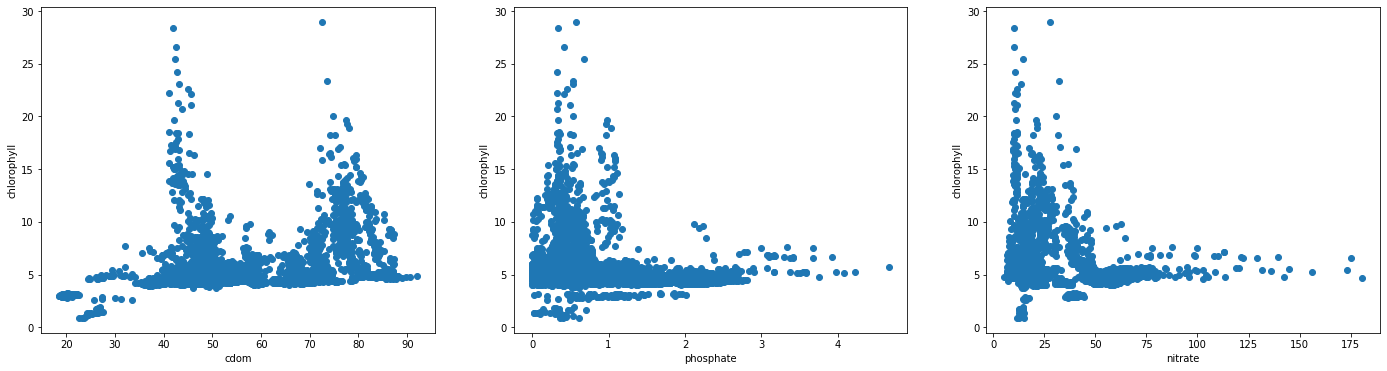

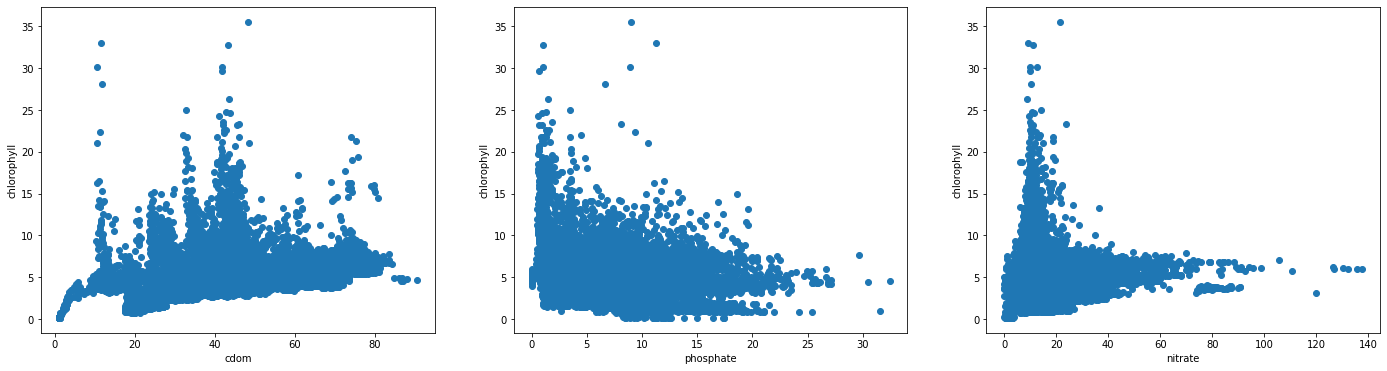

In [20]:
standard = 20
for title in ["P limit", 'N limit']:
    if title == 'P limit':
        sub_data = dataset.loc[dataset['N/P']>=standard,:]
    if title == 'N limit':
        sub_data = dataset.loc[dataset['N/P']<standard,:]
        
    nrow, ncol = 1, 3
    fig = plt.figure(figsize=(8*ncol,6*nrow))
    print(title)
    i = 0
    for nutrient in ['cdom', 'phosphate', 'nitrate']:
        i +=1
        ax = fig.add_subplot(nrow, ncol, i)
        ax.scatter(sub_data[nutrient], sub_data['chlorophyll'])
        ax.set_xlabel(nutrient)
        ax.set_ylabel('chlorophyll')

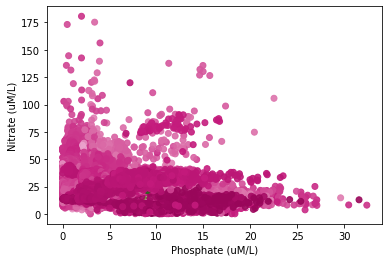

In [91]:
y = dataset['nitrate']
x = dataset['phosphate']
z = dataset['chlorophyll']
plt.scatter(x,y,c=z,alpha=0.9,cmap="PiYG")
plt.ylabel('Nitrate (uM/L)')
plt.xlabel('Phosphate (uM/L)')
plt.show()

Text(0.5, 1.0, 'Nearest')

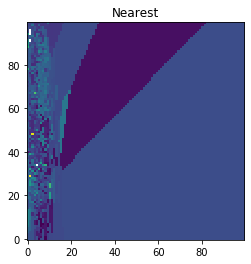

In [95]:
points = np.array(dataset[['nitrate','phosphate']])
values = np.array(dataset['chlorophyll'])
xi = np.linspace(min(x), max(x), 100)
yi = np.linspace(min(y), max(y), 100)
grid_x, grid_y = np.meshgrid(xi, yi)
grid_z0 = griddata(points, values, (grid_x, grid_y), method='nearest')
plt.imshow(grid_z0.T, origin='lower')
plt.title('Nearest')

In [63]:
#Calculate the rate of increase of nitrate, phosphate, and chlorophyll:
all_rates = [] #each object of this array is [rate nitrate, rate phosophate, rate chlorophyll]

for i in dataset.index:
    if i != 0: 
        three_rates = [] #The set of three rates of the following variables at each timepoint
        for variable in ['nitrate', 'phosphate', 'chlorophyll']:
            rate = (
                (dataset[variable][i]-dataset[variable][i-1])
                /(24*(dataset['decimal_date'][i]-dataset['decimal_date'][i-1])))
            three_rates.append(rate)
    else:
        three_rates = 3*[np.nan]
    all_rates.append(three_rates)

In [70]:
dataset['rate nitrate'] = [x[0] for x in all_rates]
dataset['rate phosphate'] = [x[1] for x in all_rates]
dataset['rate chlorophyll'] = [x[2] for x in all_rates]

(0.15, 175.4351767640252)

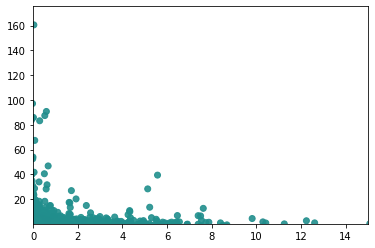

In [76]:
y = dataset['rate nitrate']
x = dataset['rate phosphate']
z = dataset['rate chlorophyll']
plt.scatter(x,y,c=z,alpha=0.9)
plt.xlim((0,15))
plt.ylim((0.150))

In [78]:
points = np.random.rand(1000, 2)
points

array([[0.46674622, 0.2871232 ],
       [0.3860818 , 0.94245067],
       [0.02361122, 0.5069238 ],
       ...,
       [0.63164309, 0.15971549],
       [0.69503748, 0.40106606],
       [0.90811684, 0.64348919]])